In [1]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import itertools
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
df = pd.read_csv('/content/drive/MyDrive/NLP/processed_data.csv')
df.head()

,label,subject,email_to,email_from,message
0,1,"Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>",Content-Type: text/html;\nContent-Transfer-Enc...
1,0,Typo in /debian/README,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,"Hi, i've just updated from the gulus and I che..."
2,1,authentic viagra,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...","Content-Type: text/plain;\n\tcharset=""iso-8859..."
3,1,Nice talking with ya,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>","Hey Billy, \n\nit was really fun going out the..."
4,1,or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",Content-Type: multipart/alternative;\n ...


In [5]:
df.shape

(75419, 5)

In [6]:
df.drop(['subject', 'email_to', 'email_from'], axis=1, inplace=True)
df.head()

,label,message
0,1,Content-Type: text/html;\nContent-Transfer-Enc...
1,0,"Hi, i've just updated from the gulus and I che..."
2,1,"Content-Type: text/plain;\n\tcharset=""iso-8859..."
3,1,"Hey Billy, \n\nit was really fun going out the..."
4,1,Content-Type: multipart/alternative;\n ...


In [7]:
df.shape

(75419, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    75419 non-null  int64 
 1   message  73932 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [9]:
# re-checking the presence of null value in column 'message'
df['message'].isnull().sum()

1487

In [10]:
# filling the null value using fillna() method
df['message'].fillna(method = 'ffill', inplace = True)
df['message'].isnull().sum()

0

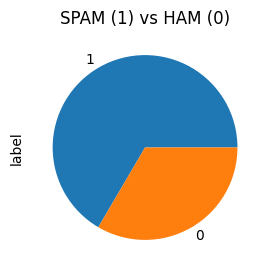

In [11]:
plt.figure(figsize=(3,3))
spam_ham = pd.value_counts(df['label'],sort = True)
spam_ham.plot(kind = 'pie')
plt.title('SPAM (1) vs HAM (0)')
plt.show()

# ***Data Preprocessing***

In [12]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [14]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer()

In [15]:
stop_words = stopwords.words('english')

In [16]:
lemmatizer = WordNetLemmatizer()

In [17]:
import re
import nltk
nltk.download('punkt')


# Preprocessing with POStagger
def preprocessing_postag(text):
    token = ''

    # Tokenize text
    token = re.findall(r'\w+', text.lower())

    # Stopword Removal and Lemmatizing
    token = [word.lower() for word in token if word.lower() not in stop_words]
    token = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in token]

    # Tagging words
    # If there are no tokens (all removed by stopwords)
    if len(token) == 0:
        return 'UNK_NN'
    # If there are tokens
    else:
        token_with_tag = nltk.pos_tag(token)

        return ' '.join([tok + '_' + tag for tok, tag in token_with_tag])

# Preprocessing with NER
def preprocessing_ner(text):
    token = ''

    # Tokenize text
    token = re.findall(r'\w+', text.lower())

    # Stopword Removal and Lemmatizing
    token = [word.lower() for word in token if word.lower() not in stop_words]
    token = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in token]

    # Tagging words
    # If there are no tokens (all removed by stopwords)
    if len(token) == 0:
        return 'UNK'
    # If there are tokens
    else:
        doc = nlp(' '.join(token))
        ner_result = [(X.text, X.label_) for X in doc.ents]

        d_token_ner = {}
        for k, v in ner_result:
            for t in tk.tokenize(k):
                d_token_ner[t] = '_' + v

        return ' '.join([tok + d_token_ner.get(tok, "") for tok in token])

#Preprocessing with NER and Posttagging
def preprocessing_nernpos(text):
    token = ''

    # Tokenize text
    token = re.findall(r'\w+', text.lower())

    # Stopword Removal and Lemmatizing
    stop_words = nltk.corpus.stopwords.words('english')
    token = [word.lower() for word in token if word.lower() not in stop_words]
    token = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in token]

    # If there are no tokens (all removed by stopwords)
    if len(token) == 0:
        return 'UNK'

    # NER and POS tagging
    doc = nlp(' '.join(token))
    ner_result = [(X.text, X.label_) for X in doc.ents]

    d_token_ner = {}
    for k, v in ner_result:
        for t in word_tokenize(k):
            d_token_ner[t] = '_' + v

    token_with_ner_pos = [tok + d_token_ner.get(tok, "") for tok in token]

    return ' '.join(token_with_ner_pos)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Bag of Words Model

WITH POST TAG + WITHOUT TFIDF

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# vectorizer = CountVectorizer(ngram_range=(1,1),  max_df = 1000, min_df=100, preprocessor=preprocessing_postag)
# X = vectorizer.fit_transform(df['message'])
# y = df['label'].values

WITH POST TAG + TFIDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),  max_df = 1000, min_df=100, preprocessor=preprocessing_postag)
X = vectorizer.fit_transform(df['message'])
y = df['label'].values

WITH NER + WITH POST TAG + WITHOUT TFIDF

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# vectorizer = CountVectorizer(ngram_range=(1,1), max_df = 1000, min_df=100, preprocessor=preprocessing_nernpos)
# X = vectorizer.fit_transform(df['message'])
# y = df['label'].values

WITH NER + WITH POST TAG + WITH TFIDF

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df = 1000, min_df= 100, preprocessor=preprocessing_nernpos)
# X = vectorizer.fit_transform(df['message'])
# y = df['label'].values

# Splitting the Data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 45)

# Using SVM

In [ ]:
clf = SVC(kernel='rbf', probability=False, tol= 0.1)
clf = clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report
y_pred_SVC = clf.predict(X_test)
print(classification_report(y_test, y_pred_SVC))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7543
           1       0.93      0.98      0.95     15083

    accuracy                           0.94     22626
   macro avg       0.94      0.91      0.93     22626
weighted avg       0.94      0.94      0.94     22626



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_SVC, average='macro')
print("Precision =", precision)
print("Recall =", recall)
print("F1-score =", fscore)

Precision = 0.9443367393663595
Recall = 0.9137925916825129
F1-score = 0.9267205845659761


In [ ]:
print('Accuracy model SVM %0.2f' % (accuracy_score(y_test, y_pred_SVC)*100), '%')

Accuracy model SVM 93.70 %


Note accuracy:
1. With Post Tagging + Tf-Idf = 95.40%
2. Without Post Tagging + Tf-idf = 98.48%
3. With Post Tagging + With NER + tanpa Tf-Idf = 93.72%
4. With Post Tagging + With NER + Tf-Idf = 98.34%

# Using KNN

In [ ]:
clf = KNeighborsClassifier(n_neighbors=7)
clf = clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report
y_pred_KNN = clf.predict(X_test)
print(classification_report(y_test, y_pred_KNN))

              precision    recall  f1-score   support

           0       0.93      0.74      0.82      7543
           1       0.88      0.97      0.92     15083

    accuracy                           0.89     22626
   macro avg       0.90      0.86      0.87     22626
weighted avg       0.90      0.89      0.89     22626



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_KNN, average='macro')
print("Precision =", precision)
print("recall =", recall)
print("fscore =", fscore)

Precision = 0.9044490082789955
recall = 0.8569173504030274
fscore = 0.8747144047622941


In [ ]:
print('Accuracy model KNN %0.2f' % (accuracy_score(y_test, y_pred_KNN)*100), '%')

Accuracy model KNN 89.46 %


Note accuracy:
1. With Post Tagging + Tf-Idf = 95.81%
2. Without Post Tagging + Tf-idf = 81.86%
3. With Post Tagging + With NER + tanpa Tf-Idf = 90.82%
4. With Post Tagging + With NER + Tf-Idf = 83.87%

# Using Naive Bayes

In [ ]:
clf = MultinomialNB(alpha=0.01)
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

In [ ]:
from sklearn.metrics import classification_report
y_pred_NB = clf.predict(X_test)
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7543
           1       0.99      0.96      0.97     15083

    accuracy                           0.97     22626
   macro avg       0.96      0.97      0.96     22626
weighted avg       0.97      0.97      0.97     22626



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_NB, average='macro')
print("Precision =", precision)
print("recall =", recall)
print("fscore =", fscore)

Precision = 0.9567490829469167
recall = 0.9688082213589819
fscore = 0.9623284197796609


In [ ]:
print('Accuracy model Naive Bayes %0.2f' % (accuracy_score(y_test, y_pred_NB)*100), '%')

Accuracy model Naive Bayes 96.61 %


Note accuracy:
1. With Post Tagging + Tf-Idf = 93.80%
2. Without Post Tagging + Tf-idf = 97.04%
3. With Post Tagging + With NER + tanpa Tf-Idf = 96.47 %
4. With Post Tagging + With NER + Tf-Idf = 96.88%

# Using Decision tree

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report
y_pred_DT = clf.predict(X_test)
print(classification_report(y_test, y_pred_DT))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      7543
           1       0.97      0.95      0.96     15083

    accuracy                           0.95     22626
   macro avg       0.94      0.95      0.94     22626
weighted avg       0.95      0.95      0.95     22626



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_DT, average='macro')
print("Precision =", precision)
print("recall =", recall)
print("fscore =", fscore)

Precision = 0.9396725230025901
recall = 0.947231167354154
fscore = 0.9432709286579462


In [ ]:
print('Accuracy model Decession Tree %0.2f' % (accuracy_score(y_test, y_pred_DT)*100), '%')

Accuracy model Decession Tree 94.91 %


Note accuracy:
1. With Post Tagging + Tf-Idf = 94.91%
2. Without Post Tagging + Tf-idf = 95.64%
3. With Post Tagging + With NER + tanpa Tf-Idf = 94.70 %
4. With Post Tagging + With NER + Tf-Idf = 95.63%

# Using Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report
y_pred_RF = clf.predict(X_test)
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      7543
           1       0.98      0.93      0.95     15083

    accuracy                           0.94     22626
   macro avg       0.93      0.95      0.94     22626
weighted avg       0.95      0.94      0.94     22626



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_RF, average='macro')
print("Precision =", precision)
print("recall =", recall)
print("fscore =", fscore)

Precision = 0.9265696957105056
recall = 0.9477589684948816
fscore = 0.9354787693396177


In [ ]:
print('Accuracy model Random Forest %0.2f' % (accuracy_score(y_test, y_pred_RF)*100), '%')

Accuracy model Random Forest 94.11 %


Note accuracy:
1. With Post Tagging + Tf-Idf = 94.11%
2. Without Post Tagging + Tf-idf = 96.42%
3. With Post Tagging + With NER + tanpa Tf-Idf = 93.86%
4. With Post Tagging + With NER + Tf-Idf = 96.22%

# Using AdaBoost

In [ ]:
clf = AdaBoostClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report
y_pred_AB = clf.predict(X_test)
print(classification_report(y_test, y_pred_AB))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77      7543
           1       0.85      0.98      0.91     15083

    accuracy                           0.87     22626
   macro avg       0.90      0.82      0.84     22626
weighted avg       0.88      0.87      0.86     22626



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_AB, average='macro')
print("Precision =", precision)
print("recall =", recall)
print("fscore =", fscore)

Precision = 0.8965317196052516
recall = 0.8159532719166065
fscore = 0.8404302556597381


In [ ]:
print('Accuracy model Ada Boost %0.2f' % (accuracy_score(y_test, y_pred_AB)*100), '%')

Accuracy model Ada Boost 87.09 %


Note accuracy:
1. With Post Tagging + Tf-Idf = 87.09%
2. Without Post Tagging + Tf-idf = 88.44%
3. With Post Tagging + With NER + tanpa Tf-Idf = 88.17%
4. With Post Tagging + With NER + Tf-Idf = 88.91%

# Using Baging

In [22]:
base_classifier = DecisionTreeClassifier()
clf = BaggingClassifier(estimator=base_classifier, n_estimators=10)

clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier())

In [23]:
from sklearn.metrics import classification_report
y_pred_Bagging = clf.predict(X_test)
print(classification_report(y_test, y_pred_Bagging))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7543
           1       0.98      0.97      0.97     15083

    accuracy                           0.96     22626
   macro avg       0.96      0.96      0.96     22626
weighted avg       0.96      0.96      0.96     22626



In [24]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_Bagging, average='macro')
print("Precision =", precision)
print("recall =", recall)
print("fscore =", fscore)

Precision = 0.9570267866931408
recall = 0.9616831015273312
fscore = 0.9592914489361123


In [25]:
print('Accuracy model Baging %0.2f' % (accuracy_score(y_test, y_pred_Bagging)*100), '%')

Accuracy model Baging 96.36 %


Note accuracy:
1. With Post Tagging + Tf-Idf = 95.36%
2. Without Post Tagging + Tf-idf = 96.36%
3. With Post Tagging + With NER + tanpa Tf-Idf = 95.35%
4. With Post Tagging + With NER + Tf-Idf = 96.29%